In [1]:
import glog
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys
import torch.nn.functional as F
from pytorch_lightning import seed_everything


sys.path.append('../../..')

import xfinai_config
from data_layer.base_dataset import FuturesDatasetRecurrent
from utils import path_wrapper, plotter

### 0 Loading Data

In [2]:
seed = 416
seed_everything(seed)

future_index= 'ic'

params = {
    "epochs":10,
    "batch_size": 64,
    "encoder_hidden_size": 128,
    "decoder_hidden_size": 128,
    "attn_size": 2,
    "seq_length": 32,
    "weight_decay": 0.03699014272607559,
    "num_layers": 1,
    "learning_rate": 0.001264079267383521,
    "dropout_prob": 0.0049846528896436
}

I0404 23:40:06.523989 7340 seed.py:69] Global seed set to 416


In [3]:
# Load data
train_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_train_data.pkl")
val_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_val_data.pkl")
test_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_test_data.pkl")

### 1 Define AttnGRU Model

In [4]:
class EncoderGRU(nn.Module):
    def __init__(self, params):
        super(EncoderGRU, self).__init__()

        self.name = 'EncoderGRU'
        self.input_size = params["input_size"]
        self.output_size = params["output_size"]
        self.num_layers = params["num_layers"]
        self.hidden_size = params["encoder_hidden_size"]
        self.device = params["device"]
        self.dropout_prob = params["dropout_prob"]
        self.gru = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers,
                          batch_first=True, dropout=self.dropout_prob)
        self.dropout = nn.Dropout(self.dropout_prob)


    def forward(self, x):
        batch_size = x.shape[0]
        h0 =  torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_(True).to(self.device)
        x, hn = self.gru(x, h0)
        return x, hn

In [5]:
class DecoderGRU(nn.Module):
    def __init__(self, params):
        super(DecoderGRU, self).__init__()

        self.name = 'DecoderGRU'
        self.input_size = params["input_size"]
        self.output_size = params["output_size"]
        self.num_layers = params["num_layers"]
        self.hidden_size = params["decoder_hidden_size"]
        self.device = params["device"]
        self.dropout_prob = params["dropout_prob"]
        self.gru = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers,
                          batch_first=True, dropout=self.dropout_prob)
        self.dropout = nn.Dropout(self.dropout_prob)
        self.fc1 = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, x, hidden):
        batch_size = x.shape[0]
        x, hn = self.gru(x, hidden)
        x = self.fc1(x)                   
        return x[:, -1, :]

In [7]:
class DecoderCell(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.input_size = params["input_size"]
        self.output_size = params["output_size"]
        self.num_layers = params["num_layers"]
        self.hidden_size = params["decoder_hidden_size"]
        self.dropout_prob = params["dropout_prob"]
        self.device = params["device"]
        self.decoder_rnn_cell = nn.GRUCell(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
        )
        self.out = nn.Linear(hidden_size, 1)
        self.attention = False
        self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, prev_hidden, y):
        rnn_hidden = self.decoder_rnn_cell(y, prev_hidden)
        output = self.out(rnn_hidden)
        return output, self.dropout(rnn_hidden)

In [ ]:
class EncoderDecoderWrapper(nn.Module):
    def __init__(self, encoder, decoder_cell, output_size=3, teacher_forcing=0.3, sequence_len=336, decoder_input=True, device='cpu'):
        super().__init__()
        self.encoder = encoder
        self.decoder_cell = decoder_cell
        self.output_size = output_size
        self.teacher_forcing = teacher_forcing
        self.sequence_length = sequence_len
        self.decoder_input = decoder_input
        self.device = device

    def forward(self, xb, yb=None):
        if self.decoder_input:
            decoder_input = xb[-1]
            input_seq = xb[0]
            if len(xb) > 2:
                encoder_output, encoder_hidden = self.encoder(input_seq, *xb[1:-1])
            else:
                encoder_output, encoder_hidden = self.encoder(input_seq)

        prev_hidden = encoder_hidden
        outputs = torch.zeros(input_seq.size(0), self.output_size, device=self.device)
        y_prev = input_seq[:, -1, 0].unsqueeze(1)
        for i in range(self.output_size):
            step_decoder_input = torch.cat((y_prev, decoder_input[:, i]), axis=1)
            if (yb is not None) and (i > 0) and (torch.rand(1) < self.teacher_forcing):
                step_decoder_input = torch.cat((yb[:, i].unsqueeze(1), decoder_input[:, i]), axis=1)
            rnn_output, prev_hidden = self.decoder_cell(prev_hidden, step_decoder_input)
            y_prev = rnn_output
            outputs[:, i] = rnn_output.squeeze(1)
        return outputs

In [6]:
params.update({"input_size": len(train_dataset.features_list),
              "device": device,
              "output_size": xfinai_config.model_config['GRU']['output_size']})
# create model instance
encoder = EncoderGRU(params).to(device)
decoder = DecoderGRU(params).to(device)

NameError: name 'train_dataset' is not defined

In [ ]:
for idx, (x_batch, y_batch) in enumerate(train_loader):

    # Convert to Tensors
    x_batch = x_batch.float().to(encoder.device)
    y_batch = y_batch.float().to(encoder.device)
    break

In [46]:
encoder_outputs, c_hidden = encoder(x_batch)

In [47]:
c_hidden.shape

torch.Size([2, 64, 128])

In [45]:
encoder_outputs.shape

torch.Size([64, 32, 128])

In [42]:
c_hidden.shape

torch.Size([64, 2, 128])

In [ ]:
nn.Linear(params['encoder_hidden_size']+27, self.max_length)

In [38]:
encoder_outputs.shape

torch.Size([64, 32, 128])

In [35]:
torch.cat(encoder_outputs[0], c_hidden[0])

TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


### 2 Create Training Func

In [7]:
def train(train_data_loader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, params):

    # Set to train mode
    encoder.train()
    decoder.train()
    running_train_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(train_data_loader):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Convert to Tensors
        x_batch = x_batch.float().to(encoder.device)
        y_batch = y_batch.float().to(encoder.device)

        # Make prediction
        c_encoder = encoder(x_batch)
        y_pred = decoder(x_batch, c_encoder)

        # Calculate loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        running_train_loss += loss.item()
        
        encoder_optimizer.step()
        decoder_optimizer.step()


    train_loss_average = running_train_loss / len(train_data_loader)
    return encoder, decoder, train_loss_average

In [8]:
def validate(val_data_loader,  encoder, decoder, criterion, params):
    # Set to eval mode
    encoder.eval()
    decoder.eval()

    running_val_loss = 0.0
    with torch.no_grad():

        for idx, (x_batch, y_batch) in enumerate(val_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(encoder.device)
            y_batch = y_batch.float().to(encoder.device)

            c_encoder = encoder(x_batch)
            y_pred = decoder(x_batch, c_encoder)
            
            val_loss = criterion(y_pred, y_batch)
            running_val_loss += val_loss.item()

    val_loss_average = running_val_loss / len(val_data_loader)
    return val_loss_average

In [11]:
def eval_model(encoder, decoder, dataloader, data_set_name, future_name, params):
    with torch.no_grad():
        y_real_list = np.array([])
        y_pred_list = np.array([])

        for idx, (x_batch, y_batch) in enumerate(dataloader):
            # Convert to Tensors
            x_batch = x_batch.float().to(encoder.device)
            y_batch = y_batch.float().to(encoder.device)

            c_encoder = encoder(x_batch)
            y_pred = decoder(x_batch, c_encoder)
            
            y_real_list = np.append(y_real_list, y_batch.squeeze(1).cpu().numpy())
            y_pred_list = np.append(y_pred_list, y_pred.squeeze(1).cpu().numpy())

    plt.figure(figsize=[15, 3], dpi=100)
    plt.plot(y_real_list, label=f'{data_set_name}_real')
    plt.plot(y_pred_list, label=f'{data_set_name}_pred')
    plt.legend()
    plt.title(f"Inference On {data_set_name} Set - {encoder.name} {future_name}")
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.subplots_adjust(bottom=0.15)

#     result_dir = path_wrapper.wrap_path(f"{xfinai_config.inference_result_path}/{future_name}/{model.name}")
#     plt.savefig(f"{result_dir}/{data_set_name}.png")
    

def save_model(model, future_name):
    dir_path = path_wrapper.wrap_path(f"{xfinai_config.model_save_path}/{future_name}")
    save_path = f"{dir_path}/{model.name}.pth"
    glog.info(f"Starting save model state, save_path: {save_path}")
    torch.save(model.state_dict(), save_path)

### 3 Run Training

In [12]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create dataset & data loader
train_dataset = FuturesDatasetRecurrent(data=train_data, label=xfinai_config.label, seq_length=params['seq_length'])
val_dataset = FuturesDatasetRecurrent(data=val_data, label=xfinai_config.label, seq_length=params['seq_length'])
test_dataset = FuturesDatasetRecurrent(data=test_data, label=xfinai_config.label, seq_length=params['seq_length'])
train_loader = DataLoader(dataset=train_dataset, **xfinai_config.data_loader_config,
                          batch_size=params['batch_size'])
val_loader = DataLoader(dataset=val_dataset, **xfinai_config.data_loader_config,
                        batch_size=params['batch_size'])
test_loader = DataLoader(dataset=test_dataset, **xfinai_config.data_loader_config,
                         batch_size=params['batch_size'])

In [18]:
params.update({"input_size": len(train_dataset.features_list),
              "device": device,
              "output_size": xfinai_config.model_config['GRU']['output_size']})
# create model instance
encoder = EncoderGRU(params).to(device)
decoder = DecoderGRU(params).to(device)

criterion = nn.MSELoss()

encoder_optimizer = optim.AdamW(encoder.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])
decoder_optimizer = optim.AdamW(decoder.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])

epochs = params['epochs']

print(encoder)
print(decoder)

train_losses = []
val_losses = []
# train the model
glog.info(f"Start Training Model")

for epoch in range(epochs):
    trained_encoder, trained_decoder, train_score = train(train_data_loader=train_loader, encoder=encoder, decoder=decoder, criterion=criterion,
                                       encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                                       params=params)
    val_score = validate(val_data_loader=val_loader, encoder=trained_encoder, decoder=trained_decoder, criterion=criterion, params=params)

    # report intermediate result
    print(f"Epoch :{epoch} train_score {train_score} val_score {val_score}")
        
    train_losses.append(train_score)
    val_losses.append(val_score)
    
glog.info(f"End Training Model")

I0404 22:34:03.653138 27812 2142800469.py:25] Start Training Model


EncoderGRU(
  (gru): GRU(27, 128, num_layers=2, batch_first=True, dropout=0.0049846528896436)
  (dropout): Dropout(p=0.0049846528896436, inplace=False)
)
DecoderGRU(
  (gru): GRU(27, 128, num_layers=2, batch_first=True, dropout=0.0049846528896436)
  (dropout): Dropout(p=0.0049846528896436, inplace=False)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)
Epoch :0 train_score 0.0038543762831900396 val_score 0.0006936065585297258
Epoch :1 train_score 0.0006095053734156057 val_score 0.0009560813668007867
Epoch :2 train_score 0.00011581659729301515 val_score 0.00011908890619685198
Epoch :3 train_score 4.7238847891100786e-05 val_score 6.48279390192422e-05
Epoch :4 train_score 9.900086799739224e-06 val_score 0.00012206086340973762
Epoch :5 train_score 1.7538227736738607e-05 val_score 0.00014635148009125632
Epoch :6 train_score 1.3322082480928321e-05 val_score 5.9271108185408266e-05
Epoch :7 train_score 1.2914698601005848e-05 val_score 6.128436888712503e-05
Epoch :8 train_score 3.1

I0404 22:36:06.162059 27812 2142800469.py:39] End Training Model


Epoch :9 train_score 4.684576727877937e-05 val_score 0.0006122677650404138


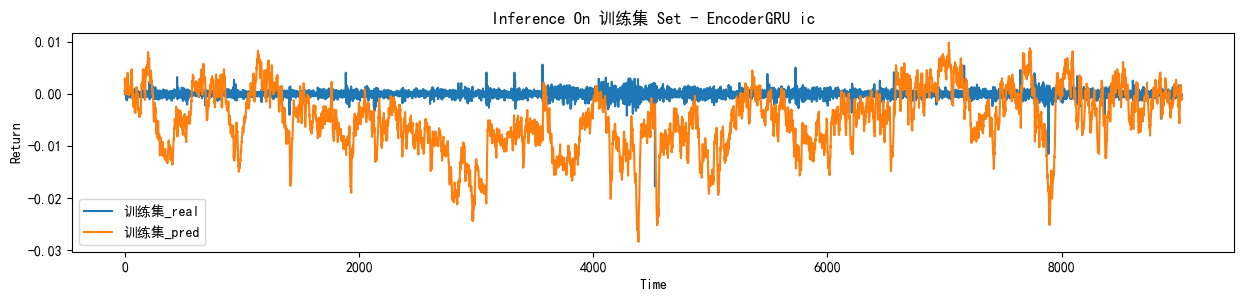

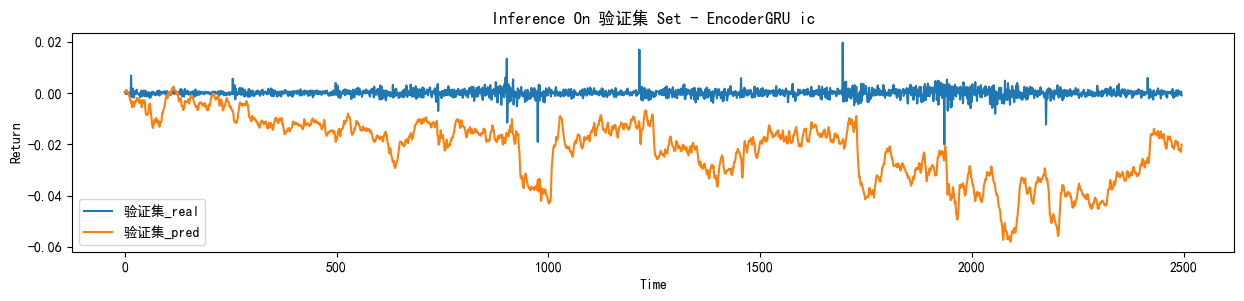

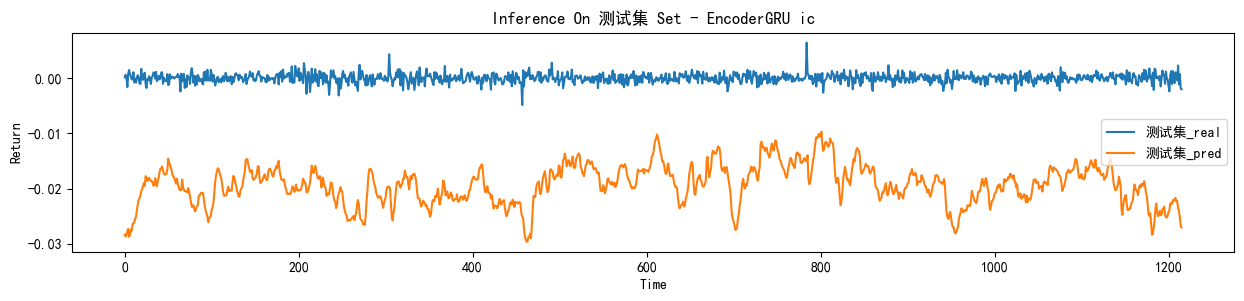

In [19]:
# eval model on 3 datasets
for dataloader, data_set_name in zip([train_loader, val_loader, test_loader],
                                     ['训练集', '验证集', '测试集']):
    eval_model(encoder=trained_encoder, decoder=trained_decoder, dataloader=dataloader, data_set_name=data_set_name,
               future_name=future_index, params=params)
    